# CS 498 AML HW 7
Roshan Rajan (rjrajan2)<br>
Kirsten Wong (kewong2)<br>
Kenneth Zhang (kfzhang2)<br>

### Mean Inference for Binary Images

#### Initialization
Read in the MNIST dataset.

In [1]:
% matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# %load mnist.py
# File for opening mnist dataset
# Source: https://gist.github.com/akesling/5358964
import os
import struct
import numpy as np

"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in xrange(len(lbl)):
        yield get_img(i)

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()


In [3]:
def to_img(img_list):
    # Note: only works on square images
    output = []
    for i in range(0,img_list.shape[0]):
        output.append(np.reshape(img_list[i],(28,28)))
    return output

In [4]:
training_data = list(read(dataset = "training", path = '.'))

In [5]:
# Get first 500 images
training_data = training_data[0:500]

Make two forms of data: list of 28x28 images, and list of length 784 pixels. The images are binarized to (-1,1)-space.

In [6]:
im_data = np.ndarray((0,784))
for i in range(0,500):
    temp = np.reshape((training_data[i][1]).astype(int),(1,784))
    temp = (temp > 0.5).astype(int) - (temp <= 0.5).astype(int)
    im_data = np.append(im_data,temp,0)

In [7]:
im_pics = to_img(im_data)

In [8]:
im_data_noisy = np.copy(im_data)

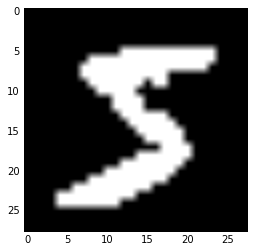

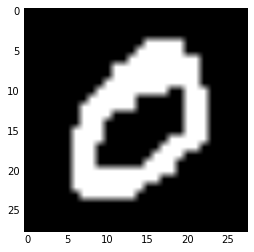

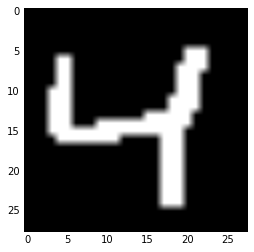

In [9]:
plt.figure()
plt.imshow(im_pics[0],cmap='gray')
plt.figure()
plt.imshow(im_pics[1],cmap='gray')
plt.figure()
plt.imshow(im_pics[2],cmap='gray')

We will use the first 500 of the training set images.
Obtain the MNIST training set, and binarize the first 500 images by mapping any value below .5 to -1 and any value above to 1. For each image, create a noisy version by randomly flipping 2% of the bits.
Now denoise each image using a Boltzmann machine model and mean field inference. Use theta_{ij}=0.2 for the H_i, H_j terms and theta_{ij}=2 for the H_i, X_j terms. To hand in: Report the fraction of all pixels that are correct in the 500 images.

In [10]:
for i in range(0,im_data.shape[0]):
    bits_to_flip = np.random.choice(784,15,replace=False)
    im_data_noisy[i][bits_to_flip] = (im_data_noisy[i][bits_to_flip])*-1

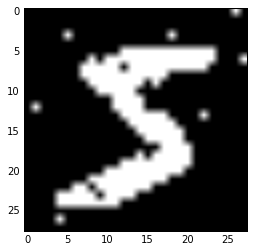

In [11]:
im_data_f = to_img(im_data_noisy)
plt.imshow(im_data_f[0],cmap="gray")

Boltzmann Model for MFI Algorithm

In [12]:
min_error = 0.01
def boltz_result(pi):
    output = np.zeros((28,28))
    for i in range(0,28):
        for j in range(0,28):
            output[i][j] = (pi[i][j] > 0.5) - int(not (pi[i][j] > 0.5))
    return output

# To be used with 2-D image
def boltzmann(img,num_iter,theta_ij):
    im_pi = np.ones((28,28)) * 0.5
    im_pi_conv = np.ones((28,28))
    while(1):
        for x in range(0,img.shape[0]):
            for y in range(0,img.shape[1]):
                z = 0.0
                if(x > 0):
                    z += theta_ij * (2*im_pi[x-1][y]-1)  + theta_ij*img[x-1][y]
                if(x < 27):
                    z += theta_ij * (2*im_pi[x+1][y]-1)  + theta_ij*img[x+1][y]
                if(y > 0):
                    z += theta_ij * (2*im_pi[x][y-1]-1)  + theta_ij*img[x][y-1]
                if(y < 27):
                    z += theta_ij * (2*im_pi[x][y+1]-1)  + theta_ij*img[x][y+1]
                    
                im_pi[x][y] = (np.exp(z) / (np.exp(-z) + np.exp(z)))
        
        rel_error = np.absolute(np.sum(im_pi_conv - im_pi))
        if  rel_error < min_error: break
        else: im_pi_conv = np.copy(im_pi)
    return im_pi

In [13]:
theta_ij = 0.2
num_iter = 10

pi_02 = np.zeros((500,28,28))
for i in range(0,pi_02.shape[0]):
    pi_02[i] = boltzmann(im_data_f[i],num_iter,theta_ij)
    
im_data_denoised_02 = np.zeros((500,28,28))

for i in range(0,im_data_denoised_02.shape[0]):
    im_data_denoised_02[i] = boltz_result(pi_02[i])

Get fraction of correctly denoised pixels over all 500 images

In [14]:
(np.sum(im_data_denoised_02 == im_pics)) / (500.0*784.0)

0.98370153061224486

Get fraction of correctly denoised pixels in each image

In [15]:
accs_02 = np.zeros(500)
for i in range(0,500):
    accs_02[i] = np.sum(im_data_denoised_02[i] == im_pics[i]) / (784.0)

Most accurate reconstruction for $\theta_{ij} = 0.2$

The Accuracy Value is 0.998724489796.


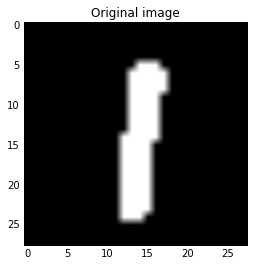

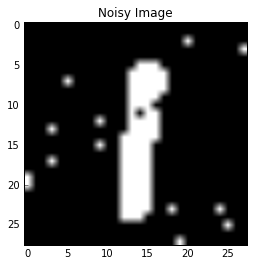

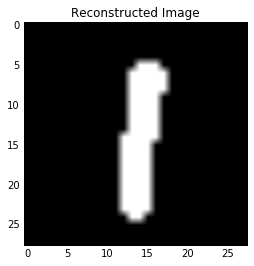

In [16]:
accs_02_max = np.argmax(accs_02)
accs_02_min = np.argmin(accs_02)
plt.imshow(im_pics[accs_02_max],cmap="gray")
plt.title('Original image')
plt.figure()
plt.imshow(im_data_f[accs_02_max],cmap="gray")
plt.title('Noisy Image')
plt.figure()
plt.imshow(im_data_denoised_02[accs_02_max],cmap="gray")
plt.title('Reconstructed Image')
print 'The Accuracy Value is {}.'.format(accs_02[accs_02_max])

Least accurate reconstruction for $\theta_{ij} = 0.2$

The Accuracy Value is 0.968112244898.


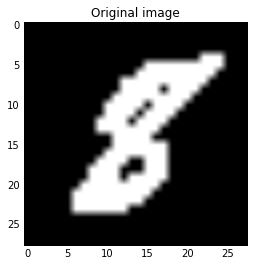

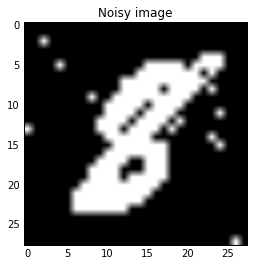

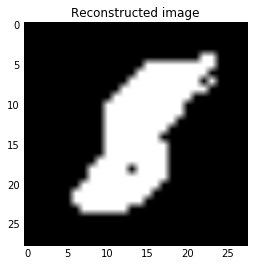

In [17]:
plt.imshow(im_pics[accs_02_min],cmap="gray")
plt.title('Original image')
plt.figure()
plt.imshow(im_data_f[accs_02_min],cmap="gray")
plt.title('Noisy image')
plt.figure()
plt.imshow(im_data_denoised_02[accs_02_min],cmap="gray")
plt.title('Reconstructed image')
print 'The Accuracy Value is {}.'.format(accs_02[accs_02_min])

Results for $\theta_{ij} = 2.0$

In [18]:
theta_ij = 2.0
pi_2 = np.zeros((500,28,28))
for i in range(0,pi_2.shape[0]):
    pi_2[i] = boltzmann(im_data_f[i],num_iter,theta_ij)
    
im_data_denoised_2 = np.zeros((500,28,28))

for i in range(0,im_data_denoised_2.shape[0]):
    im_data_denoised_2[i] = boltz_result(pi_2[i])

Get fraction of correctly denoised pixels over all 500 images

In [19]:
(np.sum(im_data_denoised_2 == im_pics)) / (500.0*784.0)

0.98177806122448985

Get fraction of correctly denoised pixels in each image

In [20]:
accs_2 = np.zeros(500)
for i in range(0,500):
    accs_2[i] = np.sum(im_data_denoised_2[i] == im_pics[i]) / (784.0)

Most accurate reconstruction for $\theta_{ij} = 2$

The Accuracy Value is 0.998724489796.


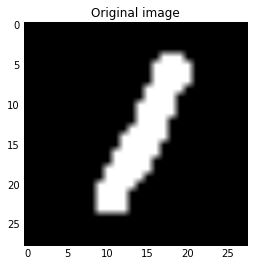

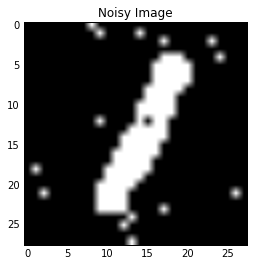

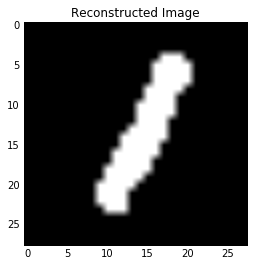

In [21]:
accs_2_max = np.argmax(accs_2)
accs_2_min = np.argmin(accs_2)
plt.imshow(im_pics[accs_2_max],cmap="gray")
plt.title('Original image')
plt.figure()
plt.imshow(im_data_f[accs_2_max],cmap="gray")
plt.title('Noisy Image')
plt.figure()
plt.imshow(im_data_denoised_2[accs_2_max],cmap="gray")
plt.title('Reconstructed Image')
print 'The Accuracy Value is {}.'.format(accs_2[accs_2_max])

Lease accurate reconstruction for $\theta_{ij} = 2$

The Accuracy Value is 0.963010204082.


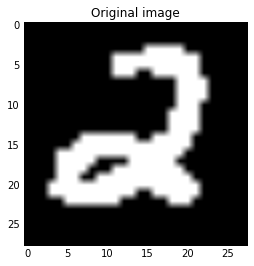

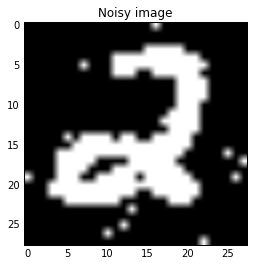

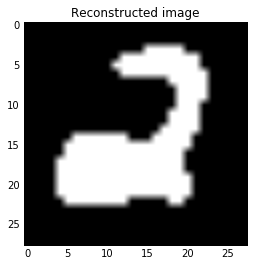

In [22]:
plt.imshow(im_pics[accs_2_min],cmap="gray")
plt.title('Original image')
plt.figure()
plt.imshow(im_data_f[accs_2_min],cmap="gray")
plt.title('Noisy image')
plt.figure()
plt.imshow(im_data_denoised_2[accs_2_min],cmap="gray")
plt.title('Reconstructed image')
print 'The Accuracy Value is {}.'.format(accs_2[accs_2_min])

ROC Curve

In [23]:
def denoiser(theta_ij, num_iter, noisy_data):
    pi = np.zeros((500,28,28))
    
    for i in range(0,pi.shape[0]):
        pi[i] = boltzmann(noisy_data[i],num_iter,theta_ij)
    
    im_data_denoised = np.zeros((500,28,28))

    for i in range(0,im_data_denoised.shape[0]):
        im_data_denoised[i] = boltz_result(pi[i])
    
    return im_data_denoised

In [24]:
im_denoised = []

for theta_ij in np.arange(-1, 1, 0.1):
    if float("{0:.1f}".format(theta_ij)) == 0: continue
    im_denoised.append((denoiser(theta_ij, num_iter, im_data_f)).reshape(500, 784))

In [25]:
def roc_calc_total(img_data, denoised_data):
    tp = fp = 0
    cond_neg = cond_pos = 0
    for i in range(0, 500):
        _, counts = np.unique(img_data[i], return_counts=True)
        cond_neg += float(counts[0])
        cond_pos += float(counts[1])
        for j in range(0, 784):
            if (img_data[i][j] == 1 and denoised_data[i][j] == 1):
                tp += 1
            if (img_data[i][j] == -1 and denoised_data[i][j] == 1):
                fp += 1
    tpr = tp/cond_pos
    fpr = fp/cond_neg
    return tpr, fpr

In [26]:
tpr = np.zeros(len(im_denoised))
fpr = np.zeros(len(im_denoised))
for i in range (0, len(im_denoised)):
    tpr[i], fpr[i] = roc_calc_total(im_data, im_denoised[i])

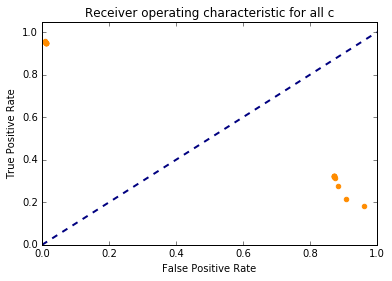

In [27]:
plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for all c')
plt.show()